In [74]:
import pandas as pd 
import os 
import datetime

# 1. 导入数据

In [75]:
#os.chdir('E://CFPS-data/')
#os.listdir()

In [76]:
# 文件路径
file_path_child = r'E:\\CFPS-data\\cfps2018childproxy_202012.dta'
file_path_famconf = r'E:\\CFPS-data\\ecfps2018famconf_202008.dta'
file_path_famecon = r'E:\\CFPS-data\\ecfps2018famecon_202101.dta'
file_path_person = r'E:\\CFPS-data\\ecfps2018person_202012.dta'
file_path_cross = r'E:\\CFPS-data\\ecfps2018crossyearid_202104.dta'

In [77]:
#data_person = pd.read_stata(file_path_person, convert_categoricals=False) 

#value labels for column wm703 are not unique.解决方法  convert_categoricals=False
data_famconf = pd.read_stata(file_path_famconf, convert_categoricals=False) 

# 2. 分析家庭关系表 data_famconf

## 2.1 列出预计会使用的变量

- id related
    - pid: 个人样本编码； 用于匹配
    - fid18 : 家庭id； 用于匹配
    - fid10 fid12 fid14 fid16 : 往次调查的家庭id
    - code_a_p： 个人户内代码，可以用于剔除同住但无直接血缘关系的人 
    - code_a18_p: 个人是否与该家庭在经济上是一家人
    - familysize18：家庭规模，是使用code_a18_p计算的

- 地址信息
    - fid_provcd18：省级  
    - fid_countyid18：区县级  
    - fid_cid18：村居级  
    - fid_urban18：城乡性质   

- 基因成员: genetype18（有细分）  gene
- 是否核心成员：COREMEMBER18

- 性别：tb2_a_p
- 出生年、月：tb1y_a_p, tb1m_a_p ;  调查年、月：cyear18, cmonth18  用于计算访问时的年龄
- 户口：hukou_a18_p
- 个人婚姻：tb3_a18_p
    - 配偶婚姻：tb3_a18_s
    - 配偶户口：hukou_a18_s
    - 配偶是否健在：alive_a18_s
    - 配偶去世原因：ta401_a18_s
- 个人问卷是否完成：cfps2018_interv_p
- 个人是否健在：alive_a18_p
- 个人去世原因：ta401_a18_p
    - 意外死亡代码：17
        - 17.0.70	机动车辆交通事故， 17.0.71	机动车以外的运输事故， 17.0.73	意外跌落，17.0.76	淹死

- 父母信息
    - pid_a_f: 父亲样本编码
    - TB6_A18_F：父亲是否居住在家
    - TB1Y_A_F：父亲出生年， TB1M_A_F:出生月
    - TA4Y_A18_F：父亲去世年份， TA4M_A18_F: 父亲去世月份
    - TA401_A18_F：去世原因
- 母亲信息
    - pid_a_m
    
    
- 子女信息
    - pid_a_c1-10：孩子样本编码
    - TB2_A_C1-10: 孩子性别
    
    
- 访问形式：iwmode18
        


## 2.2 整体了解一下数据

In [78]:
data_famconf.iloc[:,1:20].head(5)

,fid_provcd18,fid_countyid18,fid_cid18,fid_urban18,pid,fid_base,psu,fid10,fid12,fid14,fid16,familysize18,subsample,subpopulation,genetype18,rtype_end18,code_a_p,tb6_a18_p,co_a18_p
0,11.0,45.0,624942.0,1.0,100051501.0,110043.0,45.0,-8.0,-8.0,100051.0,100051.0,3.0,1.0,6.0,0.0,1.0,501.0,1.0,1.0
1,11.0,45.0,624942.0,1.0,110043107.0,110043.0,45.0,110043.0,110043.0,100051.0,100051.0,3.0,1.0,6.0,1.0,1.0,107.0,1.0,1.0
2,11.0,45.0,624942.0,1.0,100051502.0,110043.0,45.0,-8.0,-8.0,100051.0,100051.0,3.0,1.0,6.0,0.0,1.0,502.0,1.0,1.0
3,12.0,79.0,-9.0,1.0,100160601.0,120009.0,79.0,-8.0,-8.0,-8.0,-8.0,2.0,1.0,6.0,0.0,4.0,601.0,1.0,1.0
4,12.0,79.0,-9.0,1.0,120009102.0,120009.0,79.0,120009.0,120009.0,100160.0,100160.0,2.0,1.0,6.0,1.0,1.0,102.0,1.0,1.0


In [79]:
# check 缺失值； 等具体问题分析再处理数据清洗问题
data_famconf.isna().sum()

fid18              0
fid_provcd18       0
fid_countyid18     0
fid_cid18          0
fid_urban18        0
                  ..
cyear18            0
cmonth18           0
iwmode18           0
interviewerid18    0
releaseversion     0
Length: 296, dtype: int64

In [80]:
# 数据量
print('样本量（个人）和字段数量：', data_famconf.shape) 
# 家庭数量
print('家庭数量： ', data_famconf['fid18'].unique().size)
# 平均家庭规模, 若经济独立，则不在一个家庭
fam = data_famconf['fid18'].duplicated()
fam_num = data_famconf[~fam]['familysize18'].mean() 
print('家庭平均规模： ' , round(fam_num,4))
# 不基于经济独立计算
tem = data_famconf['fid18'].groupby(data_famconf['fid18']).count().mean()
print('家庭平均规模（不考虑经济独立的回答): ', round(tem,4))

样本量（个人）和字段数量： (58504, 296)
家庭数量：  15051
家庭平均规模：  3.5294
家庭平均规模（不考虑经济独立的回答):  3.8871


In [81]:
# 基因成员数量
gene = data_famconf[data_famconf['gene']==1]
core = data_famconf[data_famconf['coremember18']==1]
print('基因成员数量：', gene['gene'].count(),'; ', '人问卷完成数量： ', gene[gene['cfps2018_interv_p']==1]['gene'].count() )
print('核心成员数量： ', core['gene'].count(),'; ', '人问卷完成数量： ', core[core['cfps2018_interv_p']==1]['gene'].count() )

基因成员数量： 50016 ;  人问卷完成数量：  42385
核心成员数量：  5777 ;  人问卷完成数量：  4125


### 以下部分选择基因成员和核心成员进行分析

In [82]:
famconf = data_famconf[(data_famconf['gene']==1) | (data_famconf['coremember18']==1)]
famconf.shape

(55793, 296)

## 2.3 家庭规模分布

In [83]:
# 家庭数量
print('家庭数量： ', famconf['fid18'].unique().size)
# 平均家庭规模, 若经济独立，则不在一个家庭
fam = famconf['fid18'].duplicated()
fam_num = famconf[~fam]['familysize18'].mean() 
print('家庭平均规模： ' , round(fam_num,4))
# 家庭规模分布
print('家庭规模分布:')
famconf[~fam]['familysize18'].value_counts()

家庭数量：  15046
家庭平均规模：  3.5298
家庭规模分布:


3.0     3258
2.0     3258
4.0     2464
1.0     1888
5.0     1886
6.0     1361
7.0      495
8.0      198
9.0      105
10.0      68
11.0      26
13.0      14
12.0      13
14.0       7
15.0       2
17.0       1
16.0       1
21.0       1
Name: familysize18, dtype: int64

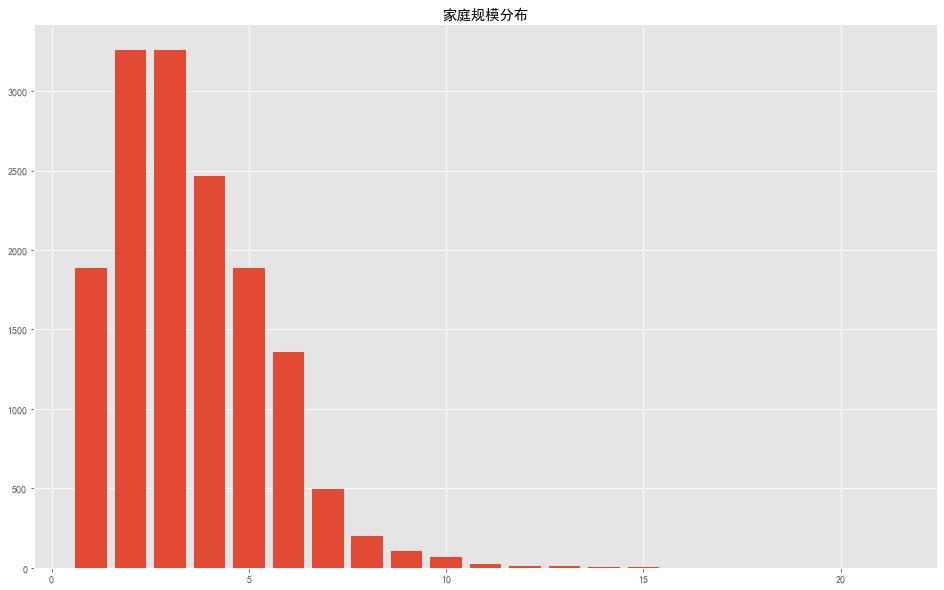

In [84]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# 设置字体
mpl.rcParams['font.sans-serif'] = ['SimHei']
# 设置风格
plt.style.use('ggplot')
a = famconf[~fam]['familysize18'].value_counts()
plt.figure(figsize=(16.18,10))
plt.bar(a.index, a.values)
plt.title('家庭规模分布')
plt.show()

## 2.4 年龄分布

In [85]:
# check data
print(famconf['tb1m_a_p'].describe())  # 月份
print(famconf['tb1y_a_p'].describe())  # 年份
# -9 为缺失值

count    55793.000000
mean         6.394619
std          3.949687
min         -9.000000
25%          3.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: tb1m_a_p, dtype: float64
count    55793.000000
mean      1972.925618
std        116.467357
min         -9.000000
25%       1963.000000
50%       1981.000000
75%       1996.000000
max       2018.000000
Name: tb1y_a_p, dtype: float64


In [86]:
print('月缺失数据：', famconf[famconf['tb1m_a_p']==-9].shape[0])
print('年缺失数据： ',famconf[famconf['tb1y_a_p']==-9].shape[0])
print('年缺失数据： ',famconf[famconf['tb1y_a_p']==-1].shape[0])  # check codebook, 年份有 -1（不知道）， -9
# 处理方法，剔除年缺失数据，月缺失数据补充月份为 6 

月缺失数据： 877
年缺失数据：  180
年缺失数据：  5


In [87]:
# famconf.loc[:,['tb1y_a_p','tb1m_a_p']]
print(famconf['tb1m_a_p'].value_counts())

 10.0    5503
 9.0     4889
 8.0     4762
 11.0    4645
 12.0    4617
 3.0     4529
 2.0     4448
 1.0     4430
 7.0     4357
 5.0     4322
 4.0     4232
 6.0     4182
-9.0      877
Name: tb1m_a_p, dtype: int64


In [88]:
# 出生年、月：tb1y_a_p, tb1m_a_p ;  调查年、月：cyear18, cmonth18  用于计算访问时的年龄
# 1. 合并年月
def combine_date(x):
#     print(x[0])
#     print(x[1])
#    print(str(x[0]).split('.')[0]+str(x[1]).split('.')[0])
    if (x[0] == -9) | (x[0] == -1):  # 剔除年份缺失数据
        return None
    else:
        if x[1] == -9:  # 月份缺失数据填 6 月
            return str(x[0]).split('.')[0]+'6'
        return str(x[0]).split('.')[0]+str(x[1]).split('.')[0]

famconf['birthday']=famconf[['tb1y_a_p','tb1m_a_p']].apply(combine_date,axis=1)
famconf['visitday']=famconf[['cyear18','cmonth18']].apply(combine_date,axis =1)
    

C:\Temp\Temp/ipykernel_16036/3948555465.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  famconf['birthday']=famconf[['tb1y_a_p','tb1m_a_p']].apply(combine_date,axis=1)
C:\Temp\Temp/ipykernel_16036/3948555465.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  famconf['visitday']=famconf[['cyear18','cmonth18']].apply(combine_date,axis =1)


In [89]:
# famconf.loc[:,['birthday']]
print(famconf['birthday'].value_counts())

19876     141
19634     136
198810    130
19902     127
198910    127
         ... 
19264       1
19187       1
19221       1
19178       1
192012      1
Name: birthday, Length: 1175, dtype: int64


In [90]:
# 2. 转换为 datetime 格式
famconf['birthday_dt']=pd.to_datetime(famconf['birthday'],format='%Y%m')
famconf['visitday_dt']=pd.to_datetime(famconf['visitday'],format='%Y%m')

C:\Temp\Temp/ipykernel_16036/3756169929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  famconf['birthday_dt']=pd.to_datetime(famconf['birthday'],format='%Y%m')
C:\Temp\Temp/ipykernel_16036/3756169929.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  famconf['visitday_dt']=pd.to_datetime(famconf['visitday'],format='%Y%m')


In [91]:
# 计算年龄 用调查时间 - 出生日期
famconf['age']=(famconf['visitday_dt']-famconf['birthday_dt']).dt.days/365 

C:\Temp\Temp/ipykernel_16036/3244559220.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  famconf['age']=(famconf['visitday_dt']-famconf['birthday_dt']).dt.days/365


Text(0.5, 1.0, '年龄分布')

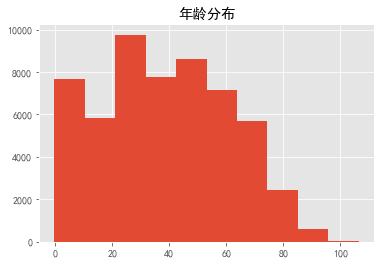

In [92]:
famconf['age'].hist()
plt.title('年龄分布')

In [93]:
# 年龄分段
age_cut = [-1, 16, 23,46,60,120]
age_seg = pd.cut(famconf['age'],bins = age_cut,labels=['0-16','16-22','23-45','46-60','60+'])
famconf['age_segment']= age_seg.values
a = famconf['age_segment'].value_counts()
a

C:\Temp\Temp/ipykernel_16036/2414485417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  famconf['age_segment']= age_seg.values


23-45    18862
60+      11307
0-16     10789
46-60    10666
16-22     3984
Name: age_segment, dtype: int64

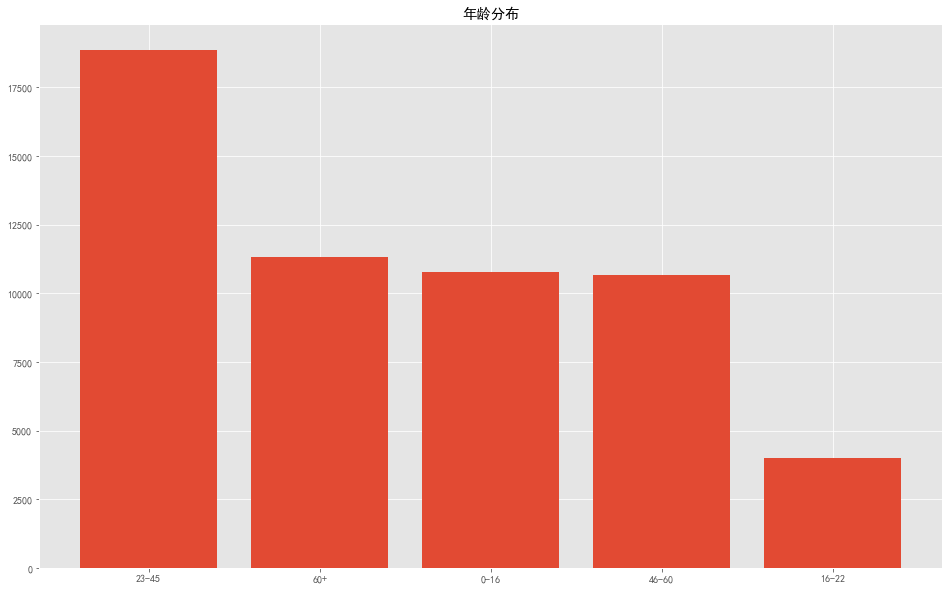

In [94]:
plt.figure(figsize=(16.18,10))
plt.bar(a.index, a.values)
plt.title('年龄分布')
plt.show()

In [95]:
# 新生儿数量
print('age < 4: ', famconf[famconf['age']<4].shape[0])
print('age < 3: ', famconf[famconf['age']<3].shape[0])
print('age < 2: ', famconf[famconf['age']<2].shape[0])
print('age < 1: ', famconf[famconf['age']<1].shape[0])

age < 4:  3112
age < 3:  2369
age < 2:  1563
age < 1:  725


In [96]:
# 年龄 + 性别  0：女  1：男
pd.crosstab(age_seg,famconf['tb2_a_p'])

tb2_a_p,-9.0,0.0,1.0
age,,,
0-16,7,5082,5700
16-22,1,1967,2016
23-45,1,9404,9457
46-60,2,5267,5397
60+,0,5905,5402


In [97]:
# 年龄 + 婚姻情况 
# -1：不知道； -8：不适用； 1：未婚； 2：在婚（有配偶）；3：同居； 4：离婚； 5：丧偶
pd.crosstab(age_seg,famconf['tb3_a18_p'])

tb3_a18_p,-8.0,1.0,2.0,3.0,4.0,5.0
age,,,,,,
0-16,7884,2901,3,1,0,0
16-22,36,3521,384,23,17,3
23-45,282,2842,14942,70,650,76
46-60,148,145,9654,40,317,362
60+,670,81,8075,45,112,2324


In [98]:
# 个人是否健在
pd.crosstab(age_seg,famconf['alive_a18_p'])

alive_a18_p,0.0,1.0
age,,
0-16,4,10785
16-22,2,3982
23-45,29,18833
46-60,78,10588
60+,583,10724


In [99]:
# 配偶是否健在， 应该是和上一次调查的时间相比的变化
pd.crosstab(age_seg,famconf['alive_a18_s'])

alive_a18_s,-8.0,-1.0,0.0,1.0
age,,,,
0-16,10788,0,0,1
16-22,3720,0,0,264
23-45,5595,1,5,13261
46-60,1054,0,7,9605
60+,2933,0,132,8242


In [100]:
# some check
tem = famconf[(famconf['alive_a18_p'] == 0)& (famconf['alive_a18_s'] == 1)]['pid_a_s'][0:2]
famconf[famconf['pid'] == tem.values[1]]['tb3_a18_p']  #  = 5  丧偶
famconf[famconf['pid'] == tem.values[1]]['alive_a18_s']  #  = -8   但不是在这个调查阶段去世的？
# famconf[famconf['pid'] == tem.values[1]]['pid_a_s'] # -8   如果配偶去世，配偶就没有pid了
# Q:需要看的问题：如果是基因成员，去世了还是会在调察的家庭关系表中吗？ check 往年数据

367   -8.0
Name: alive_a18_s, dtype: float64

In [101]:
# 年龄 + 户口
# -1：不知道； -9：缺失； 1：农业户口； 3：非农业户口； 5：没有户口； 79：不适用(非中国国籍)
pd.crosstab(age_seg,famconf['hukou_a18_p'])

hukou_a18_p,-9.0,-1.0,1.0,3.0,5.0,79.0
age,,,,,,
0-16,48,2,8401,2110,211,17
16-22,3,0,3216,758,4,3
23-45,102,0,14006,4722,16,16
46-60,13,0,7956,2675,11,11
60+,18,0,8008,3246,17,18


In [102]:
pd.crosstab(age_seg,famconf['hukou_a18_s'])
# -8：不适用； -9：缺失
# 15-22 年龄段的户口数量 < 配偶数量  对应的是 配偶是否健在为 -8 

hukou_a18_s,-9.0,-8.0,-1.0,1.0,3.0,5.0,79.0
age,,,,,,,
0-16,0,10787,0,2,0,0,0
16-22,0,3720,0,246,18,0,0
23-45,5,5428,1,10047,3358,11,12
46-60,0,1007,0,7281,2360,6,12
60+,0,2918,0,5865,2515,6,3


## 2.5 子女情况 

In [103]:
famconf[famconf['pid_a_c1']==77]['tb1y_a_c1']  # 77： 离家

5944    -8.0
5945    -8.0
6661    -8.0
7639    -8.0
7640    -8.0
8470    -8.0
8471    -8.0
9996    -8.0
14808   -8.0
16709   -8.0
16710   -8.0
17198   -8.0
17686   -8.0
25665   -8.0
29190   -8.0
29193   -8.0
34164   -8.0
38431   -8.0
40955   -8.0
41336   -8.0
42941   -8.0
43262   -8.0
43541   -8.0
43542   -8.0
44811   -8.0
44812   -8.0
45261   -8.0
47378   -8.0
47870   -8.0
48193   -8.0
49054   -8.0
51046   -8.0
52750   -8.0
55694   -8.0
57621   -8.0
Name: tb1y_a_c1, dtype: float64

In [104]:
child_list = ['child'+str(i) for i in range(0,10)]


In [105]:
female_df = famconf[famconf['tb2_a_p']==0] # 选择女性

# 新建df存储信息
## 列名称
child_col = ['f_pid','m_pid','marriage','total_child']
child_col.extend(child_list)
## 初始化字典存储数据
tem = {}
for i in child_col:
    tem[i]=[]

for i,j in enumerate(female_df['pid']):
    data = female_df.iloc[i]
    # 我們需要考虑结过婚 和 未婚有小孩儿的情况
    if (data['tb3_a18_p']==2) | (data['tb3_a18_p']==4)|(data['tb3_a18_p']==5)| (data['pid_a_c1'] >1000000):        
        
        # 1. wife and hunsband info
        tem['f_pid'].append(j)  # pid
        tem['marriage'].append(data['tb3_a18_p']) #婚姻状态
        tem['m_pid'].append(data['pid_a_s']) # 配偶pid
        
        # 2. child info
        for k in range(10):
            tem[child_list[k]].append(data['pid_a_c'+str(k+1)])
        
        # 3 计算有几个小孩儿
        for k in range(10):
            if tem[child_list[-(k+1)]][-1]>1000000:
                tem['total_child'].append(10 - k)
                break
            if k == 9:
                tem['total_child'].append(0)
    #tem.append(female['pid_a_s']) # 配偶pid, -8 79 为不适用

In [106]:
# 生成dataframe
child_info_df = pd.DataFrame(tem)
# 整理完之後的數據，注意，家庭的F，M有可能是別的F，M的子女

In [107]:
# checking data
male_list = child_info_df.m_pid.values
female_list = child_info_df.f_pid.values

count1 = 0  # husband have pid, but no data info
count2 = 0  # use male pid to get wife pid, which is invalid
count3 = 0  # use male pid to get wife pid, but not in female_list
count4 = 0  # use male pid to get wife pid, wife also in female_list though not the same as original wife
queshi = 0   # no pid
for i,j in enumerate(male_list):
    #print(i)
    if j == -8  or j == 79:   # -8: 缺失； 79 不适用
        queshi += 1  #数量 4075 
        continue
    else:
        try:
            temp_f =  famconf[famconf['pid'] == j]['pid_a_s'].iloc[0]
        except:
            # 有一些配偶有PID，但没有信息;  原因，配偶在上期之前已去世 或 alive 數據缺失，所以，此处没有数据
            #print(female_list[i],j)
            count1 += 1   # 數量：373
            continue
    temp2_f =  child_info_df.iloc[i]['f_pid']
    if temp_f != temp2_f:   # wife is not consistent
        if temp_f < 1000000:
            count2 +=1  # 數量：145  
        else:
            if (temp_f not in female_list) :
                count3 += 1   #數量： 26  數據問題，由 husband id 找到的wife 沒有 data, 暫不考慮此問題，也許是離異再婚造成的？
                print('case 3:', j,temp_f, female_list[i])
            else:
                count4 += 1 #   數量 2  數據有問題，需要檢查修改
                print('case 4:', j,temp_f, female_list[i])
        

case 3: 140061103.0 237144551.0 140061601.0
case 3: 140677104.0 135643551.0 140677601.0
case 3: 520327102.0 214972501.0 520327101.0
case 3: 430561103.0 257422551.0 289374601.0
case 3: 621317103.0 295643551.0 621317501.0
case 3: 360190103.0 243601551.0 360190601.0
case 3: 410339101.0 410339102.0 410339601.0
case 3: 411436106.0 262068551.0 411436601.0
case 4: 411450107.0 411450502.0 411450602.0
case 3: 411773103.0 194085551.0 411773601.0
case 3: 430439103.0 631880601.0 430439601.0
case 3: 441656103.0 163035551.0 441656601.0
case 3: 450175104.0 231754551.0 450175601.0
case 3: 510186103.0 248752551.0 510186601.0
case 3: 510397101.0 510397552.0 510397102.0
case 3: 510593101.0 180827551.0 510593601.0
case 3: 510911581.0 510911203.0 510911105.0
case 3: 520211104.0 197781551.0 520211601.0
case 3: 410796103.0 143756551.0 530103601.0
case 3: 411035104.0 261778551.0 548612601.0
case 3: 510457103.0 510457204.0 588238601.0
case 3: 620352101.0 250909552.0 620352203.0
case 3: 620553106.0 182778551.0 

In [108]:
count1,count2,count3, count4,queshi

(373, 145, 26, 2, 4075)

In [109]:
# check case 4
# 621479101.0 621479102.0 621479601.0    621479102 沒有丈夫的data, 建議刪除
# 411450107.0 411450502.0 411450602.0   數據有無， 411450107 的妻子應爲  411450602 需要調整, 而且兩個人的小孩兒數量不一樣，需要想想怎麽處理
print(famconf_pid.loc[621479101][['tb3_a18_p','pid_a_s','fid18','pid_a_c1']].tolist())
print(famconf_pid.loc[621479601][['tb3_a18_p','pid_a_s','fid18','pid_a_c1']].tolist())
print(famconf_pid.loc[621479102][['tb3_a18_p','pid_a_s','fid18','pid_a_c1']].tolist())   # husband data missing, so delete this data
print('-'*20)
print(famconf_pid.loc[411450107][['tb3_a18_p','pid_a_s','fid18','alive_a18_p','pid_a_c1','age']].tolist())
print(famconf_pid.loc[411450602][['tb3_a18_p','pid_a_s','fid18','alive_a18_p','pid_a_c1','age']].tolist())
print(famconf_pid.loc[411450502][['tb3_a18_p','pid_a_s','fid18','alive_a18_p','pid_a_c1','age']].tolist())  # hunsband: 411450103 not the same as 411450107
print(famconf_pid.loc[411450103][['tb3_a18_p','pid_a_s','fid18','alive_a18_p','pid_a_c3','age']].tolist())

NameError: name 'famconf_pid' is not defined

In [ ]:
# check CASE 3
# case 3: 140061103.0 237144551.0 140061601.0  # 237144551 no inpusts
# case 3: 140677104.0 135643551.0 140677601.0
# case 3: 520327102.0 214972501.0 520327101.0

print(famconf_pid.loc[140677104][['tb3_a18_p','pid_a_s','fid18','alive_a18_p','pid_a_c2','age']].tolist())
print(famconf_pid.loc[140677601][['tb3_a18_p','pid_a_s','fid18','alive_a18_p','pid_a_c2','age']].tolist())
#print(famconf_pid.loc[135643551][['tb3_a18_p','pid_a_s','fid18','alive_a18_p','pid_a_c1','age']].tolist()) 

print('-'*20)

print(famconf_pid.loc[520327102][['tb3_a18_p','pid_a_s','fid18','alive_a18_p','pid_a_c2','age']].tolist())
print(famconf_pid.loc[520327101][['tb3_a18_p','pid_a_s','fid18','alive_a18_p','pid_a_c2','age']].tolist())
# print(famconf_pid.loc[214972501][['tb3_a18_p','pid_a_s','fid18','alive_a18_p','pid_a_c1','age']].tolist()) 

In [ ]:
# check male sample  如果有男性未婚有小孩，或者喪偶、離婚的情況需要加入
male_df = famconf[famconf['tb2_a_p']==1] # 选择男性

tem = {}
for i in child_col:
    tem[i]=[]
for i,j in enumerate(male_df['pid']):
    # 如果male 沒有在 child_info_df中，則check是否需要補充數據
    if j not in male_list:
        data = male_df.iloc[i]
        # 我們需要考虑结过婚 和 未婚有小孩儿的情况
        if (data['tb3_a18_p']==2) | (data['tb3_a18_p']==4)|(data['tb3_a18_p']==5)| (data['pid_a_c1'] >1000000):        

            # 1. wife and hunsband info
            tem['m_pid'].append(j)  # pid
            tem['marriage'].append(data['tb3_a18_p']) #婚姻状态
            tem['f_pid'].append(data['pid_a_s']) # 配偶pid

            # 2. child info
            for k in range(10):
                tem[child_list[k]].append(data['pid_a_c'+str(k+1)])

            # 3 计算有几个小孩儿
            for k in range(10):
                if tem[child_list[-(k+1)]][-1]>1000000:
                    tem['total_child'].append(10 - k)
                    break
                if k == 9:
                    tem['total_child'].append(0)
        #tem.append(female['pid_a_s']) # 配偶pid, -8 79 为不适用

In [ ]:
# 生成dataframe
child_info_df2 = pd.DataFrame(tem)
# 整理完之後的數據，注意，家庭的F，M有可能是別的F，M的子女

In [ ]:
# 合并兩個表, 數據細節還需要再處理，清洗未完成
child_info_total = pd.concat([child_info_df, child_info_df2], axis = 0)

In [ ]:
famconf.columns[2:30]

In [ ]:
famconf_pid = famconf.copy()
famconf_pid.set_index('pid',inplace = True)  # set pid as index
# 加入一些數據方便後續處理
# 加入女性和男性的年龄和alive info
temp = famconf_pid[['age','age_segment','alive_a18_p']]
temp.columns = ['f_age', 'f_age_segment','f_alive']
child_info_total2 = pd.merge(child_info_total, temp, left_on='f_pid', right_index = True, how = 'left') # 合并两个表
temp.columns = ['m_age', 'm_age_segment','m_alive']
child_info_total2 = pd.merge(child_info_total2, temp, left_on='m_pid', right_index = True, how = 'left')

In [ ]:
print(child_info_total2.head(2))
print('--------')
print('data amount:', child_info_total2.shape)
print('------------')
print('marriage status:')
print(child_info_total2.marriage.value_counts())
print('-'*10)
print('child amount:')
child_info_total2.total_child.value_counts()

In [ ]:
pd.crosstab(child_info_total2['m_age_segment'],child_info_total2['total_child'])

In [ ]:
pd.crosstab(child_info_total2['f_age_segment'],child_info_total2['total_child'])

In [ ]:
child_info_total2[child_info_total2['m_age_segment']=='0-16']
# 数据有问题：2.16岁有的小孩，不对
# 需要清洗掉有小孩儿的年纪< 13 且 需check 年纪 - 孩子年纪 > 13,未做
# 加入孩子的年纪进一步分析，未做

# 3 家庭问卷库  famecon

## 3.1. 列出预计会使用的变量

- finance
    - fn3: 是否领取离退休或养老金； fn301 领取离退休或养老金总额（元）
    - fn401: 子女给的钱（元）（不同住子女）
    - FN4	亲戚给的钱（元）
    - FN5	其他人给的钱（元）

  
    - fp510 教育培训支出
    - FQ2 房屋归谁所有
        1：家庭成员有完全产权
        2： 部分产权
        3： 单位提供的房子
        4：廉租房； 5： 公租房；6：租的商品房； 7：亲戚、朋友的房子
    - FQ6 房子当前市价
        - FQ6_MAX： 当前市价最大值
        - FQ_MIN: 最小值
    - FR1： 是否还有房产
        - FR101：还有几处房产
        - FR2： 其它房产市价总价
        - FR2_MAX, FR2_MIN, FR2_EST
        
    - FS6V: 耐用品消费总值（元）
    
    - 金融资产
        - FT1：现金及存款总额（元）
            - FT1_MAX, FT1_MIN, FT1_EST
            - FT101: 定期存款总额
            
        - FT200：是否持有金融产品
            - FT201： 金融产品总价
            
    - 负债：
        - FT3： 是否贷款买房或装修
            - FT301： 待偿房贷本息总额（万元）
        - FT4	是否购房建房装修借款
            - FT401	购房建房装修借款额度（元）
        - FT5	待偿银行贷款（除房贷） 是否
            - FT501	您家待偿贷款额（元）
        - FT6 待偿亲友借款 是否
            -  FT601 您家待偿亲友借款（元）
	
    - FAMILYSIZE18: 家庭人口规模（综合变量）
        - fml_count 2018年家庭成员人口数 （加载的是Rtype = 1-5, 7(外出家庭成员）的成员，不包括同住（经济独立）的家庭成员
    
    - FSWT_NATCS18N：家庭横截面权数
	
	
	


In [110]:
data_famecon = pd.read_stata(file_path_famecon, convert_categoricals=False) 

In [111]:
data_famecon.shape

(14218, 321)

In [112]:
data_famecon.iloc[0:5,0:20]

,fid18,fid16,fid14,fid12,fid10,provcd18,countyid18,cid18,urban18,iwmode,feinterv,fml_count,pid_a_1,pid_a_2,pid_a_3,pid_a_4,pid_a_5,pid_a_6,pid_a_7,pid_a_8
0,100051.0,100051.0,100051.0,110043.0,110043.0,11.0,45.0,624942.0,1.0,2.0,1.0,3.0,100051501.0,100051502.0,110043107.0,-8.0,-8.0,-8.0,-8.0,-8.0
1,100160.0,100160.0,100160.0,120009.0,120009.0,12.0,79.0,NaN,1.0,1.0,1.0,2.0,120009102.0,100160601.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0
2,100286.0,100286.0,100286.0,130005.0,130005.0,13.0,239.0,NaN,1.0,2.0,1.0,1.0,130005103.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0
3,100435.0,100435.0,100435.0,130155.0,130155.0,13.0,52.0,121200.0,0.0,2.0,1.0,4.0,100435552.0,130155103.0,130155521.0,277731501.0,-8.0,-8.0,-8.0,-8.0
4,100453.0,100453.0,100453.0,100453.0,430111.0,43.0,29.0,533420.0,1.0,1.0,1.0,6.0,100453401.0,100453431.0,100453551.0,430111101.0,430111102.0,430111103.0,-8.0,-8.0


In [113]:
# fml_count 与 fmilysize18 不同，区别还需要理一下
a = data_famecon['fml_count'] <= data_famecon['familysize18']
sum(~a) 

687

## 3.2 家庭资产分析

#### 资产
    - 房产 fq2 (=1,=2), fr1
        - 价值 
            - fq6, fq6_max, fq6_min
            - fr2, fr2_max, fr2_min, fr2_est
    - 耐用品
        - 消费总值：fs6v
        
    - 金融资产 FT200：是否持有金融产品
        - FT201： 金融产品总价
#### 负债
    - FT3： 是否贷款买房或装修
        - FT301： 待偿房贷本息总额（万元）
    - FT4   是否购房建房装修借款
        - FT401  购房建房装修借款额度（元）
    - FT5   待偿银行贷款（除房贷） 是否
        - FT501  您家待偿贷款额（元）
    - FT6 待偿亲友借款 是否
        -  FT601 您家待偿亲友借款（元）


### 3.2.1 整体简要分析

In [114]:
# 资产整理，沒有用權數調整
famecon = data_famecon.set_index('fid18')

In [115]:
# participation rate
# 資產
famecon['housing'] = [1 if (i[1]['fq2'] == 1) or (i[1]['fq2'] == 2) or (i[1]['fr1'] == 1) else 0 for i in famecon[['fq2','fr1']].iterrows()]
famecon['durable'] = [1 if i>0 else 0 for i in famecon['fs6v'].values]
famecon['fin_asset'] = [1 if i == 1 else 0 for i in famecon['ft200'].values]
# 負債
famecon['mortgage'] = [1 if i==1 else 0 for i in famecon['ft3'].values]
famecon['bank_loan'] = [1 if i==1 else 0 for i in famecon['ft5'].values]
famecon['friend_loan'] = [1 if i == 1 else 0 for i in famecon['ft6'].values]

In [116]:
print('Participation rate')
famecon[['housing','durable','fin_asset','mortgage','bank_loan','friend_loan']].apply(lambda x: sum(x)/len(x))

Participation rate


housing        0.845196
durable        0.909833
fin_asset      0.056970
mortgage       0.116894
bank_loan      0.096146
friend_loan    0.128991
dtype: float64

In [117]:
# 不同家庭人平均年龄看一下participation rate
result = famecon[['housing','durable','fin_asset','mortgage','bank_loan','friend_loan']].groupby(famecon['fml_count']).agg(lambda x: sum(x)/len(x))

In [118]:
result 

,housing,durable,fin_asset,mortgage,bank_loan,friend_loan
fml_count,,,,,,
1.0,0.484830,0.762743,0.055825,0.052184,0.072209,0.078277
2.0,0.833718,0.908941,0.060046,0.063345,0.052458,0.091389
3.0,0.869822,0.929652,0.082840,0.152860,0.100592,0.115385
4.0,0.896479,0.931269,0.058125,0.151039,0.106067,0.149767
5.0,0.935329,0.943346,0.047568,0.140032,0.129343,0.166221
6.0,0.960624,0.951709,0.025260,0.134473,0.130015,0.176820
7.0,0.967010,0.936082,0.022680,0.142268,0.134021,0.208247
8.0,0.959391,0.913706,0.015228,0.081218,0.106599,0.197970
9.0,0.950980,0.921569,0.049020,0.127451,0.107843,0.117647


C:\Temp\Temp/ipykernel_16036/3988926344.py:16: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(result.index[0:9],#传入数据x


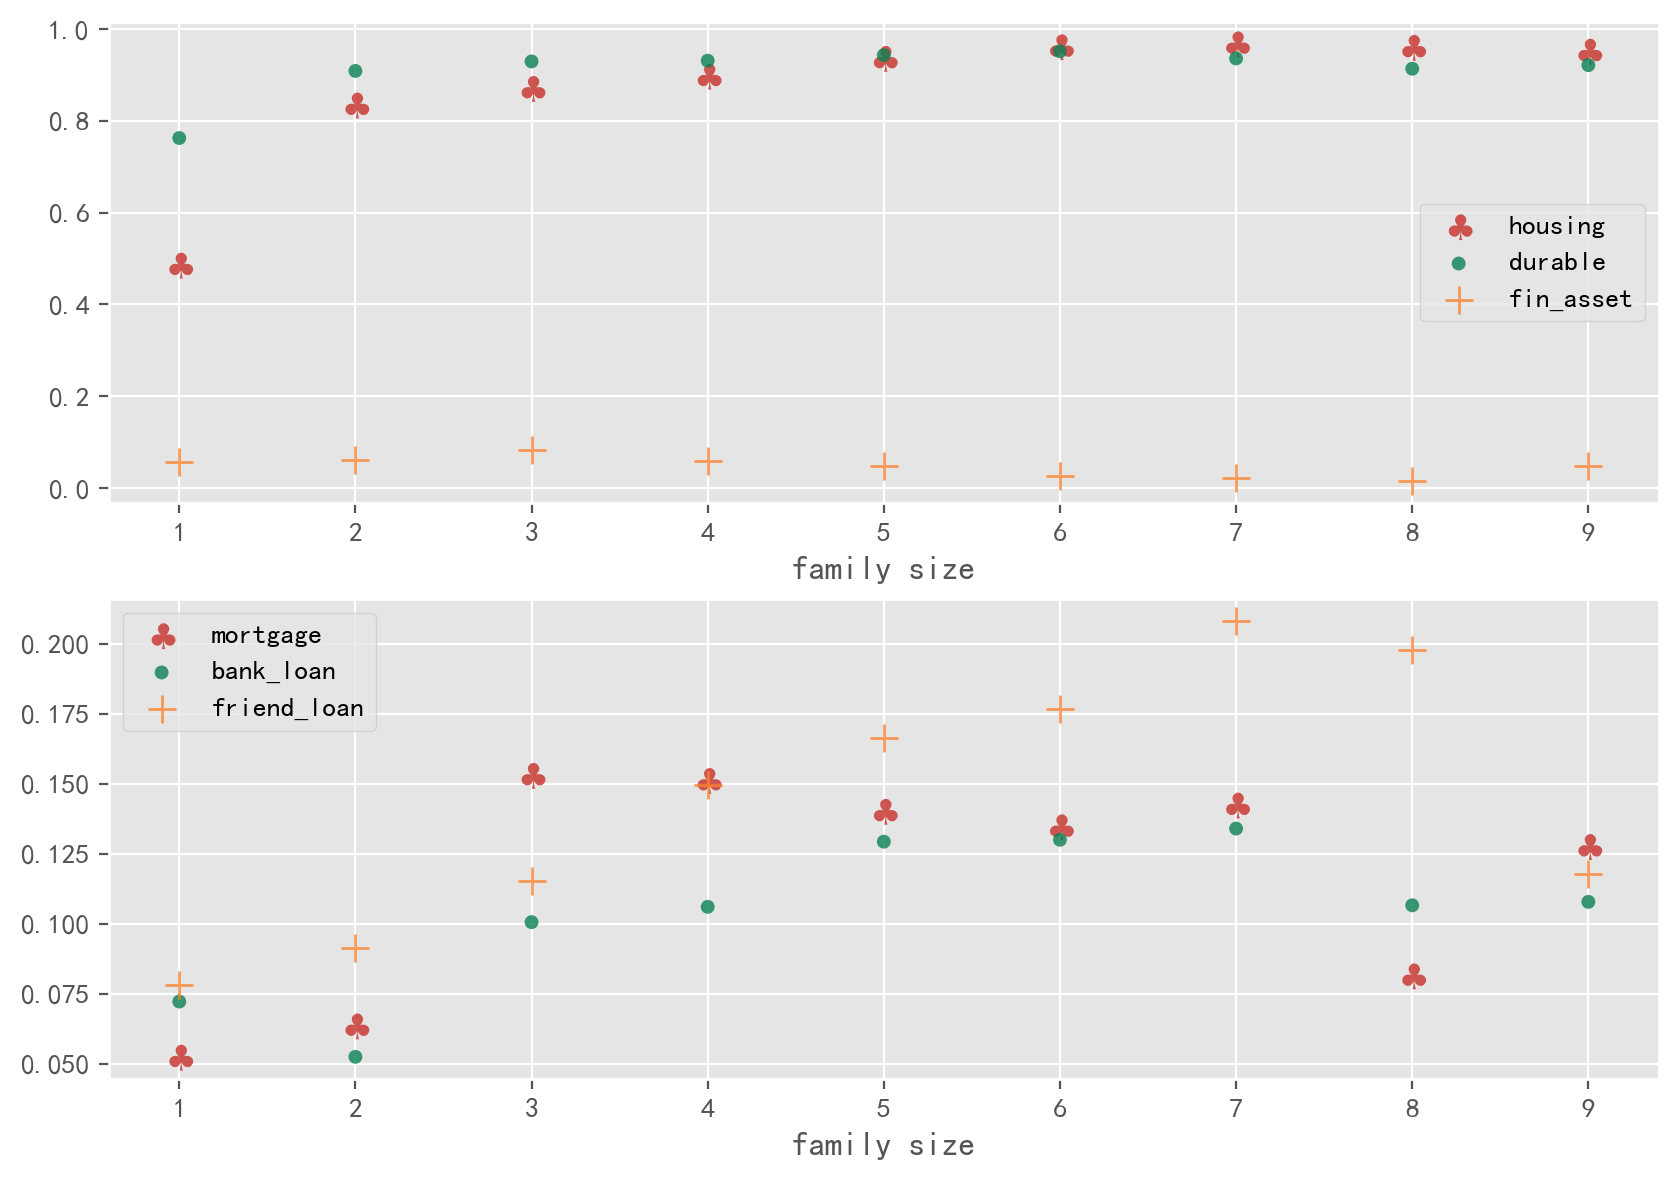

In [119]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# 设置字体
mpl.rcParams['font.sans-serif'] = ['SimHei']
# 设置风格
plt.style.use('ggplot')
colors = ['#c72e29','#098154','#fb832d']#三种不同颜色
markers = ['$\clubsuit$','.','+']#三种不同图形

fig = plt.figure(figsize=(10,7),dpi=200)

# plt.scatter(result.index[0:10], result.iloc[0:10,0])
for j in [1,2]:
    ax = fig.add_subplot(2,1,j)
    for i in range(3):
        ax.scatter(result.index[0:9],#传入数据x
                   result.iloc[0:9,(j-1)*3+i],#传入数据y
                    s = 100,#散点图形（marker）的大小
                    c = colors[i],#marker颜色
                    marker = markers[i],#marker形状
                    #marker=matplotlib.markers.MarkerStyle(marker = markers[i],fillstyle='full'),#设置marker的填充
                    alpha=0.8,#marker透明度，范围为0-1
                    facecolors='r',#marker的填充颜色，当上面c参数设置了颜色，优先c
                    edgecolors='none',#marker的边缘线色
                    linewidths=1,#marker边缘线宽度，edgecolors不设置时，该参数不起作用
                    label = result.columns[(j-1)*3+i])#后面图例的名称取自label
         
 
    plt.legend(loc = 'best')
    plt.xlabel('family size')
plt.show()

## 3.3 老年人财产的描述性统计

老年人财产来源：退休金(fn301)、子女给的钱(fn401)、亲戚给的钱(fn4)、其他人给的钱(fn5)

In [120]:
famecon.loc[:,['fn3','fn301','fn401','fn4','fn5']]

,fn3,fn301,fn401,fn4,fn5
fid18,,,,,
100051.0,5.0,-8.0,0.0,0.0,0.0
100160.0,5.0,-8.0,0.0,10000.0,0.0
100286.0,5.0,-8.0,0.0,0.0,0.0
100435.0,5.0,-8.0,0.0,0.0,0.0
100453.0,1.0,50000.0,0.0,0.0,0.0
...,...,...,...,...,...
6609501.0,5.0,-8.0,0.0,0.0,0.0
6646971.0,5.0,-8.0,0.0,0.0,0.0
6694541.0,5.0,-8.0,0.0,0.0,0.0


In [121]:
def total_assets(x):
    if (x[0]==-8):     #-8:无退休金
        return x[1]+x[2]+x[3]
    return x[0]+x[1]+x[2]+x[3]

famecon['elderly_asset']=famecon[['fn301','fn401','fn4','fn5']].apply(total_assets,axis=1)

In [122]:
print(famecon['elderly_asset'].value_counts())

0.0        6577
2000.0      344
1000.0      341
10000.0     229
20000.0     220
           ... 
1505.0        1
6840.0        1
11320.0       1
18760.0       1
1099.0        1
Name: elderly_asset, Length: 1214, dtype: int64


In [123]:
print(famecon['elderly_asset'].describe())

count      14218.000000
mean       10390.715572
std        26691.787812
min           -3.000000
25%            0.000000
50%          500.000000
75%         6000.000000
max      1000000.000000
Name: elderly_asset, dtype: float64


In [124]:
#财产分段
asset_cut=[-3,3001,7001,10001,30001,70001,1000000]
asset_seg=pd.cut(famecon['elderly_asset'],bins=asset_cut,labels=['0-3000','3001-7000','7001-10000','10001-30000','30001-70000','70001+'])
famecon['asset_segment']=asset_seg.values
c=famecon['asset_segment'].value_counts()
c

0-3000         9789
10001-30000    1348
30001-70000    1101
3001-7000      1011
70001+          486
7001-10000      482
Name: asset_segment, dtype: int64

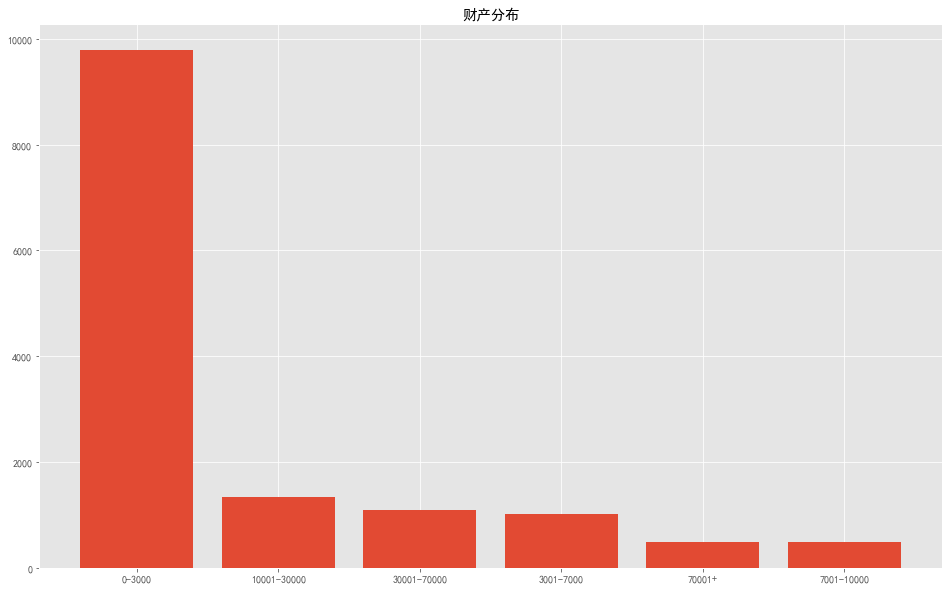

In [125]:
plt.figure(figsize=(16.18,10))
plt.bar(c.index, c.values)
plt.title('财产分布')
plt.show()

# 4 跨年库 cross和个人库 person

## 4.1 家庭成员有身故、病重、意外比例


- 跨年库
    - alive18：18年是否存活；
    - deathcause_code：死亡原因；
- 个人库
    - qp303：是否病重

In [126]:
data_cross = pd.read_stata(file_path_cross, convert_categoricals=False) 
data_person = pd.read_stata(file_path_person, convert_categoricals=False) 

In [127]:
print(data_cross['alive18'].value_counts()) #0：去世；1：健在；-8：不适用

 1.0    57781
-8.0    15448
 0.0      901
Name: alive18, dtype: int64


In [128]:
death=data_cross[data_cross['alive18']==0]
death.loc[:,:].head(5)

,pid,birthy,gender,ethnicity,entrayear,fidbaseline,psu,subsample,subpopulation,fid10,...,cfps2018sch,cfps2018eduy,cfps2018eduy_im,urban18,hk18,employ18,genetype18,coremember18,alive18,releaseversion
290,110060581.0,1912.0,0.0,3.0,2016.0,110060.0,45.0,1.0,6.0,-8.0,...,-9.0,-9.0,-9.0,-8.0,3.0,-8.0,0.0,1.0,0.0,2018.1
328,110074101.0,1948.0,1.0,1.0,2010.0,110074.0,45.0,1.0,6.0,110074.0,...,-9.0,-9.0,-9.0,-8.0,-8.0,-8.0,7.0,-8.0,0.0,2018.1
366,110092102.0,1938.0,0.0,1.0,2010.0,110092.0,45.0,1.0,6.0,110092.0,...,-9.0,-9.0,-9.0,-8.0,-8.0,-8.0,7.0,-8.0,0.0,2018.1
416,110119581.0,1924.0,0.0,NaN,2016.0,110119.0,45.0,1.0,6.0,-8.0,...,1.0,0.0,0.0,-8.0,5.0,-8.0,0.0,0.0,0.0,2018.1
418,110120102.0,1959.0,1.0,1.0,2010.0,110120.0,45.0,1.0,6.0,110120.0,...,-9.0,-9.0,-9.0,-8.0,-8.0,-8.0,7.0,-8.0,0.0,2018.1


In [129]:
print(data_person['qp303'].value_counts()) #1：不严重；3：一般；5：严重；-8：不适用;-1:未知

-8.0    23630
 3.0     4188
 5.0     3646
 1.0     1628
-1.0        5
Name: qp303, dtype: int64


In [130]:
seriously_ill=data_person[data_person['qp303']==5]
seriously_ill.loc[:,:]

,pid,code,fid18,fid16,fid14,fid12,fid10,pid_a_f,pid_a_m,selfrpt,...,cfps2018eduy_im,gdge,gdgeyear,gdgemonth,catipilot,pg02,pg1201_min,pg1201_max,interviewerid18,releaseversion
7,100810551.0,551.0,100810.0,100810.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,6.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,803368.0,2.1
8,101129501.0,501.0,101129.0,101129.0,101129.0,-8.0,-8.0,-8.0,-8.0,1.0,...,9.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,477664.0,2.1
15,103923551.0,551.0,103923.0,103923.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,707372.0,2.1
54,110026104.0,104.0,110026.0,110026.0,110026.0,110026.0,110026.0,110026204.0,110026205.0,1.0,...,9.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,831811.0,2.1
59,110031101.0,101.0,110031.0,110031.0,110031.0,110031.0,110031.0,110031201.0,110031202.0,1.0,...,12.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,831811.0,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37272,732190501.0,501.0,732190.0,732190.0,732190.0,-8.0,-8.0,-8.0,-8.0,1.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,508549.0,2.1
37281,766521551.0,551.0,766521.0,766521.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,660846.0,2.1
37318,903892431.0,431.0,903892.0,903892.0,903892.0,903892.0,-8.0,903892432.0,903892433.0,1.0,...,12.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,533008.0,2.1
37323,912238554.0,554.0,912238.0,912238.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,605017.0,2.1


In [131]:
seriously_ill.append(death,ignore_index=True)

,pid,code,fid18,fid16,fid14,fid12,fid10,pid_a_f,pid_a_m,selfrpt,...,inroster18,indsurvey18,selfrpt18,co_a18_p,marriage_18,hk18,employ18,genetype18,coremember18,alive18
0,100810551.0,551.0,100810.0,100810.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101129501.0,501.0,101129.0,101129.0,101129.0,-8.0,-8.0,-8.0,-8.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,103923551.0,551.0,103923.0,103923.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,110026104.0,104.0,110026.0,110026.0,110026.0,110026.0,110026.0,110026204.0,110026205.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,110031101.0,101.0,110031.0,110031.0,110031.0,110031.0,110031.0,110031201.0,110031202.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4542,621848102.0,NaN,621848.0,621848.0,621848.0,621848.0,621848.0,NaN,NaN,NaN,...,1.0,0.0,-8.0,0.0,2.0,-8.0,-8.0,7.0,-8.0,0.0
4543,621852102.0,NaN,621852.0,621852.0,621852.0,621852.0,621852.0,NaN,NaN,NaN,...,1.0,0.0,-8.0,0.0,2.0,-8.0,-8.0,7.0,-8.0,0.0
4544,621859101.0,NaN,621859.0,621859.0,621859.0,621859.0,621859.0,NaN,NaN,NaN,...,1.0,0.0,-8.0,0.0,2.0,-8.0,-8.0,7.0,-8.0,0.0
4545,723113434.0,NaN,723113.0,-8.0,723113.0,723113.0,-8.0,NaN,NaN,NaN,...,1.0,0.0,-8.0,0.0,5.0,1.0,-8.0,0.0,0.0,0.0


In [132]:
s1=seriously_ill['fid18'].unique().size
s=data_cross['fid18'].unique().size
print('家庭成员身故/病重占比：',round(s1/s,4))

家庭成员身故/病重占比： 0.2095


## 4.2 家庭成员因意外导致无法工作的比例

- 个人库
    - qgb6(没有工作的原因)：1-不需要/不想工作；2-照料家庭；3-退休/离休；4-年纪大了；5-因残障/疾病没有劳动能力；6-无合适的工作；7-上学/培训；77-其他

In [133]:
print(data_person['qgb6'].value_counts())

-8.0     25936
 4.0      1918
 2.0      1886
 3.0      1517
 5.0       941
 6.0       371
 77.0      345
 1.0       141
 7.0        40
-1.0         2
Name: qgb6, dtype: int64


In [134]:
unable_to_work=data_person[data_person['qgb6']==5]
unable_to_work.loc[:,:]

,pid,code,fid18,fid16,fid14,fid12,fid10,pid_a_f,pid_a_m,selfrpt,...,cfps2018eduy_im,gdge,gdgeyear,gdgemonth,catipilot,pg02,pg1201_min,pg1201_max,interviewerid18,releaseversion
41,110015104.0,104.0,110015.0,110015.0,110015.0,110015.0,110015.0,110015203.0,110015102.0,1.0,...,12.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,831811.0,2.1
109,110076101.0,101.0,110076.0,110076.0,110076.0,110076.0,110076.0,-8.0,-8.0,1.0,...,15.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,761040.0,2.1
231,120036102.0,102.0,120036.0,120036.0,120036.0,120036.0,120036.0,120036206.0,120036207.0,1.0,...,2.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,459505.0,2.1
278,120081102.0,102.0,120081.0,120081.0,120081.0,120081.0,120081.0,120081106.0,120081101.0,1.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,381518.0,2.1
290,120087102.0,102.0,120087.0,120087.0,120087.0,120087.0,120087.0,120087201.0,-8.0,1.0,...,6.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,381518.0,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36872,621726102.0,102.0,621726.0,621726.0,621726.0,621726.0,621726.0,621726203.0,621726204.0,1.0,...,9.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,651846.0,2.1
36875,621727103.0,103.0,621727.0,621727.0,621727.0,621727.0,621727.0,621727207.0,621727208.0,1.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,651846.0,2.1
36951,621772101.0,101.0,621772.0,621772.0,621772.0,621772.0,621772.0,621772201.0,621772202.0,1.0,...,6.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,847181.0,2.1
37145,621858102.0,102.0,621858.0,621858.0,621858.0,621858.0,621858.0,621858203.0,621858204.0,1.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,243845.0,2.1


In [135]:
s3=unable_to_work['fid18'].unique().size
print('家庭成员因意外导致无法工作占比：',round(s3/s,4))

家庭成员因意外导致无法工作占比： 0.0595
